## SETUP (installation et import des packages)

In [10]:
# Mettre à jour pip
#pip install --upgrade pip

# Installer les bibliothèques nécessaires
#pip install pandas scipy matplotlib numpy seaborn statsmodels

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import statsmodels.api as sm
import seaborn as sns
from scipy.stats import fisher_exact, chi2_contingency, pearsonr, shapiro, spearmanr,kruskal

## Import des CSV : Customers, Products et Transactions

### Customers

In [11]:
df_customers = pd.read_csv('customers.csv', sep=';')
print("il y a ", df_customers.shape[0],'entrées et ',df_customers.shape[1],'colonnes')
df_customers.head()


il y a  8621 entrées et  3 colonnes


,client_id,sex,birth
0,c_4410,f,1967
1,c_7839,f,1975
2,c_1699,f,1984
3,c_5961,f,1962
4,c_5320,m,1943


In [12]:
#Verification d'unicité de l'id client
df_customers.nunique()

client_id    8621
sex             2
birth          76
dtype: int64

In [13]:
#verification des type des données et des valeurs manquantes
df_customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8621 entries, 0 to 8620
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   client_id  8621 non-null   object
 1   sex        8621 non-null   object
 2   birth      8621 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 202.2+ KB


### Products

In [14]:
df_products = pd.read_csv('products.csv',sep=';')
print("il y a ", df_products.shape[0],'entrées et ',df_products.shape[1],'colonnes')
df_products.head()

il y a  3286 entrées et  3 colonnes


,id_prod,price,categ
0,0_1421,19.99,0
1,0_1368,5.13,0
2,0_731,17.99,0
3,1_587,4.99,1
4,0_1507,3.99,0


In [15]:
df_products.nunique()

id_prod    3286
price      1454
categ         3
dtype: int64

In [16]:
df_products.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3286 entries, 0 to 3285
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id_prod  3286 non-null   object 
 1   price    3286 non-null   float64
 2   categ    3286 non-null   int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 77.1+ KB


### Transactions

In [17]:
df_transactions = pd.read_csv('Transactions.csv',sep=';', parse_dates = ['date'],
  dtype={
        'id_prod': 'str',  # Exemple : forcer une colonne à être une chaîne
        'session_id': 'str',
        'client_id': 'str'
         })
print("il y a ", df_transactions.shape[0],'entrées et ',df_transactions.shape[1],'colonnes')
df_transactions.head()

il y a  1048575 entrées et  4 colonnes


,id_prod,date,session_id,client_id
0,0_1259,2021-03-01 00:01:07.843138,s_1,c_329
1,0_1390,2021-03-01 00:02:26.047414,s_2,c_664
2,0_1352,2021-03-01 00:02:38.311413,s_3,c_580
3,0_1458,2021-03-01 00:04:54.559692,s_4,c_7912
4,0_1358,2021-03-01 00:05:18.801198,s_5,c_2033


In [18]:
df_transactions.tail()

,id_prod,date,session_id,client_id
1048570,NaN,NaT,NaN,NaN
1048571,NaN,NaT,NaN,NaN
1048572,NaN,NaT,NaN,NaN
1048573,NaN,NaT,NaN,NaN
1048574,NaN,NaT,NaN,NaN


In [19]:
df_transactions.nunique()
#21 produits qui n'ont pas été vendus 
#21 clients qui n'ont pas achetés de produits (8621 dans customers et 8600 dans transactions)

id_prod         3265
date          687415
session_id    345505
client_id       8600
dtype: int64

## Jointure

In [20]:
df_merge = pd.merge(df_transactions, df_customers, on='client_id')
df_merge = pd.merge(df_merge, df_products, on='id_prod')
df_merge.sort_values(by='date', ascending=False, inplace=True)
df_merge.tail()

,id_prod,date,session_id,client_id,sex,birth,price,categ
4,0_1358,2021-03-01 00:05:18.801198,s_5,c_2033,f,1956,16.49,0
3,0_1458,2021-03-01 00:04:54.559692,s_4,c_7912,f,1989,6.55,0
2,0_1352,2021-03-01 00:02:38.311413,s_3,c_580,m,1988,4.50,0
1,0_1390,2021-03-01 00:02:26.047414,s_2,c_664,m,1960,19.37,0
0,0_1259,2021-03-01 00:01:07.843138,s_1,c_329,f,1967,11.99,0


In [21]:
df_merge.shape[0]

687534

In [22]:
df_merge.nunique()

id_prod         3265
date          687415
session_id    345505
client_id       8600
sex                2
birth             76
price           1442
categ              3
dtype: int64

## Calcul Chiffre d'affaire

In [23]:
chiffre_affaire = round(df_merge['price'].sum(),2)
print("le chiffre d'affaire est de ", chiffre_affaire,'€')

le chiffre d'affaire est de  12027663.1 €


In [24]:

# Transformation du timestamp en date
df_merge['date'] = pd.to_datetime(df_merge['date'])
# Chiffre d'affaires par jour
ca_par_jour = df_merge.groupby(df_merge['date'].dt.date)['price'].sum().round(2)

# Chiffre d'affaires par semaine
# Utilisation de la fonction resample : fonctionne comme un groupby mais sur des séries temporelles
# df.resample('fréquence', on='colonne_date').operation()
ca_par_semaine = df_merge.resample('W', on='date')['price'].sum().round(2)
# Chiffre d'affaires par mois
ca_par_mois = df_merge.resample('ME', on='date')['price'].sum().round(2) #ME = Month end


print("CA par jour :\n", ca_par_jour)
print("CA par semaine :\n", ca_par_semaine)
print("CA par mois :\n", ca_par_mois)

CA par jour :
 date
2021-03-01    16565.22
2021-03-02    15486.45
2021-03-03    15198.69
2021-03-04    15196.07
2021-03-05    17471.37
                ...   
2023-02-24    15207.89
2023-02-25    15761.25
2023-02-26    16304.72
2023-02-27    19170.81
2023-02-28    18105.15
Name: price, Length: 730, dtype: float64
CA par semaine :
 date
2021-03-07    110463.28
2021-03-14    105693.24
2021-03-21    112059.08
2021-03-28    109441.07
2021-04-04    107895.66
                ...    
2023-02-05    113486.13
2023-02-12    112528.15
2023-02-19    114121.61
2023-02-26    112245.15
2023-03-05     37275.96
Freq: W-SUN, Name: price, Length: 105, dtype: float64
CA par mois :
 date
2021-03-31    482440.61
2021-04-30    476109.30
2021-05-31    492943.47
2021-06-30    484088.56
2021-07-31    482835.40
2021-08-31    482284.79
2021-09-30    507240.68
2021-10-31    494733.16
2021-11-30    516167.73
2021-12-31    525917.28
2022-01-31    525338.99
2022-02-28    535571.50
2022-03-31    515456.53
2022-04-30   

In [25]:
# Moyenne mobile sur 7 jours (une semaine)
ca_par_jour_mm = ca_par_jour.rolling(window=7).mean().round(2)

# Moyenne mobile sur 30 jours (un mois)
ca_par_jour_mm_30 = ca_par_jour.rolling(window=30).mean().round(2)

print("Moyenne mobile sur 7 jours :\n", ca_par_jour_mm)
print("Moyenne mobile sur 30 jours :\n", ca_par_jour_mm_30)

Moyenne mobile sur 7 jours :
 date
2021-03-01         NaN
2021-03-02         NaN
2021-03-03         NaN
2021-03-04         NaN
2021-03-05         NaN
                ...   
2023-02-24    16488.78
2023-02-25    16006.75
2023-02-26    16035.02
2023-02-27    16487.57
2023-02-28    16513.98
Name: price, Length: 730, dtype: float64
Moyenne mobile sur 30 jours :
 date
2021-03-01         NaN
2021-03-02         NaN
2021-03-03         NaN
2021-03-04         NaN
2021-03-05         NaN
                ...   
2023-02-24    16238.37
2023-02-25    16188.07
2023-02-26    16162.44
2023-02-27    16282.37
2023-02-28    16321.90
Name: price, Length: 730, dtype: float64


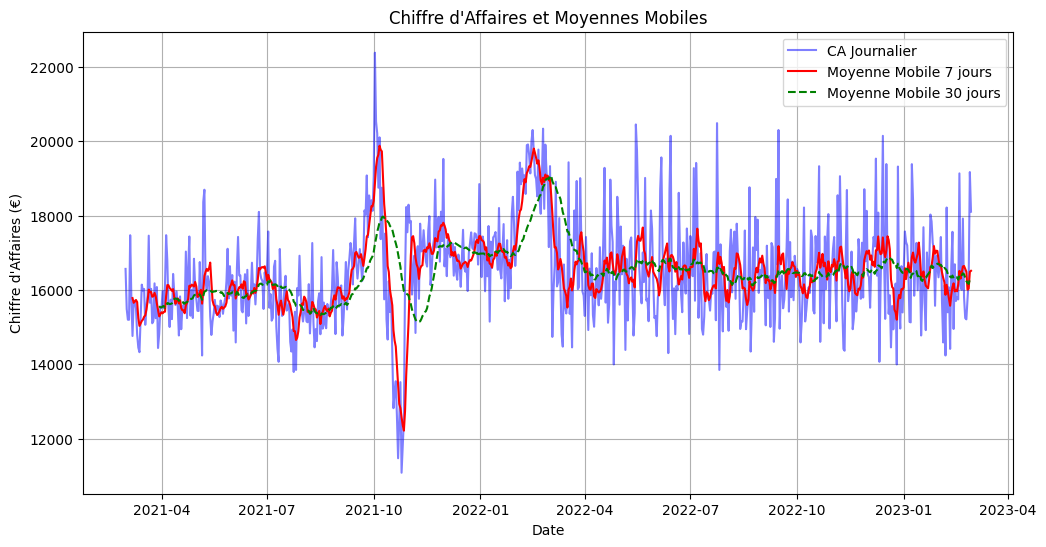

In [26]:


plt.figure(figsize=(12, 6))
plt.plot(ca_par_jour, label='CA Journalier', color='blue', alpha=0.5)
plt.plot(ca_par_jour_mm, label='Moyenne Mobile 7 jours', color='red')
plt.plot(ca_par_jour_mm_30, label='Moyenne Mobile 30 jours', color='green', linestyle='dashed')

plt.xlabel("Date")
plt.ylabel("Chiffre d'Affaires (€)")
plt.title("Chiffre d'Affaires et Moyennes Mobiles")
plt.legend()
plt.grid()
plt.show()

## Evolution du CA par catégorie

C:\Users\Pimi\AppData\Local\Temp\ipykernel_49244\3539161870.py:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  ca_categ_0_monthly = ca_categ_0.resample('M').sum()
C:\Users\Pimi\AppData\Local\Temp\ipykernel_49244\3539161870.py:8: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  ca_categ_1_monthly = ca_categ_1.resample('M').sum()
C:\Users\Pimi\AppData\Local\Temp\ipykernel_49244\3539161870.py:9: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  ca_categ_2_monthly = ca_categ_2.resample('M').sum()


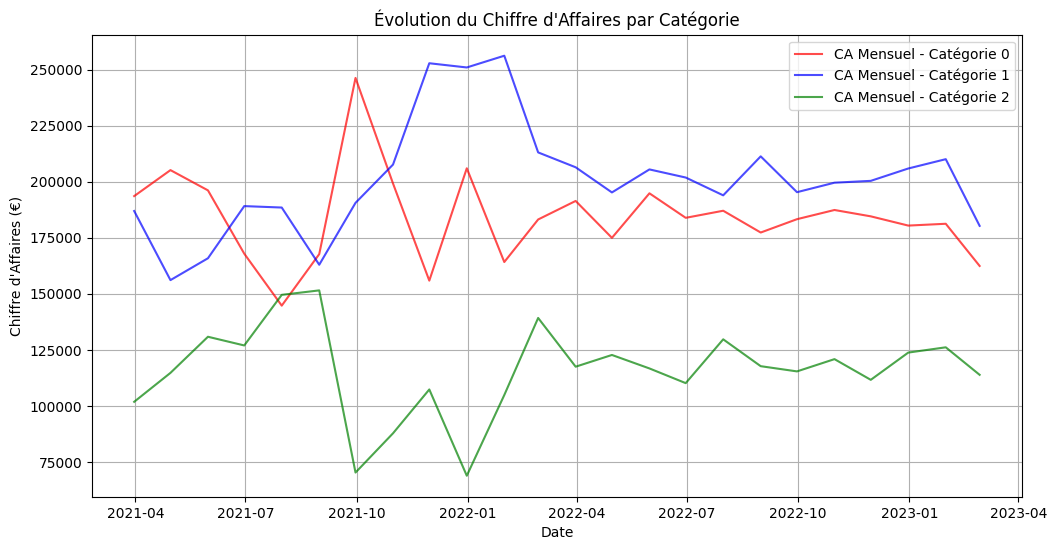

In [27]:

# Filtre les données pour chaque catégorie :
ca_categ_0 = df_merge[df_merge['categ'] == 0].set_index('date')['price']
ca_categ_1 = df_merge[df_merge['categ'] == 1].set_index('date')['price']
ca_categ_2 = df_merge[df_merge['categ'] == 2].set_index('date')['price']

# Rééchantillonne les données par mois et calcul du CA mensuel
ca_categ_0_monthly = ca_categ_0.resample('M').sum()
ca_categ_1_monthly = ca_categ_1.resample('M').sum()
ca_categ_2_monthly = ca_categ_2.resample('M').sum()

# Graphique
plt.figure(figsize=(12, 6))
plt.plot(ca_categ_0_monthly.index, ca_categ_0_monthly, label='CA Mensuel - Catégorie 0', color='red', alpha=0.7)
plt.plot(ca_categ_1_monthly.index, ca_categ_1_monthly, label='CA Mensuel - Catégorie 1', color='blue', alpha=0.7)
plt.plot(ca_categ_2_monthly.index, ca_categ_2_monthly, label='CA Mensuel - Catégorie 2', color='green', alpha=0.7)

plt.xlabel("Date")
plt.ylabel("Chiffre d'Affaires (€)")
plt.title("Évolution du Chiffre d'Affaires par Catégorie")
plt.legend()
plt.grid()
plt.show()

Le chiffre d’affaires varie significativement selon la catégorie.
La catégorie 1 est dominante en termes de performance.
La catégorie 2 semble plus fragile avec des variations brusques.
Depuis début 2022 le CA de ces 3 catégories s'est stabilisé

## Nombre de clients par mois

In [28]:
nb_client_par_mois = df_merge.resample('ME', on='date')['client_id'].nunique()
print(nb_client_par_mois)

date
2021-03-31    5676
2021-04-30    5674
2021-05-31    5644
2021-06-30    5659
2021-07-31    5672
2021-08-31    5642
2021-09-30    5693
2021-10-31    6190
2021-11-30    5875
2021-12-31    5867
2022-01-31    5809
2022-02-28    5729
2022-03-31    5835
2022-04-30    5695
2022-05-31    5843
2022-06-30    5717
2022-07-31    5778
2022-08-31    5805
2022-09-30    5738
2022-10-31    5755
2022-11-30    5749
2022-12-31    5765
2023-01-31    5828
2023-02-28    5587
Freq: ME, Name: client_id, dtype: int64


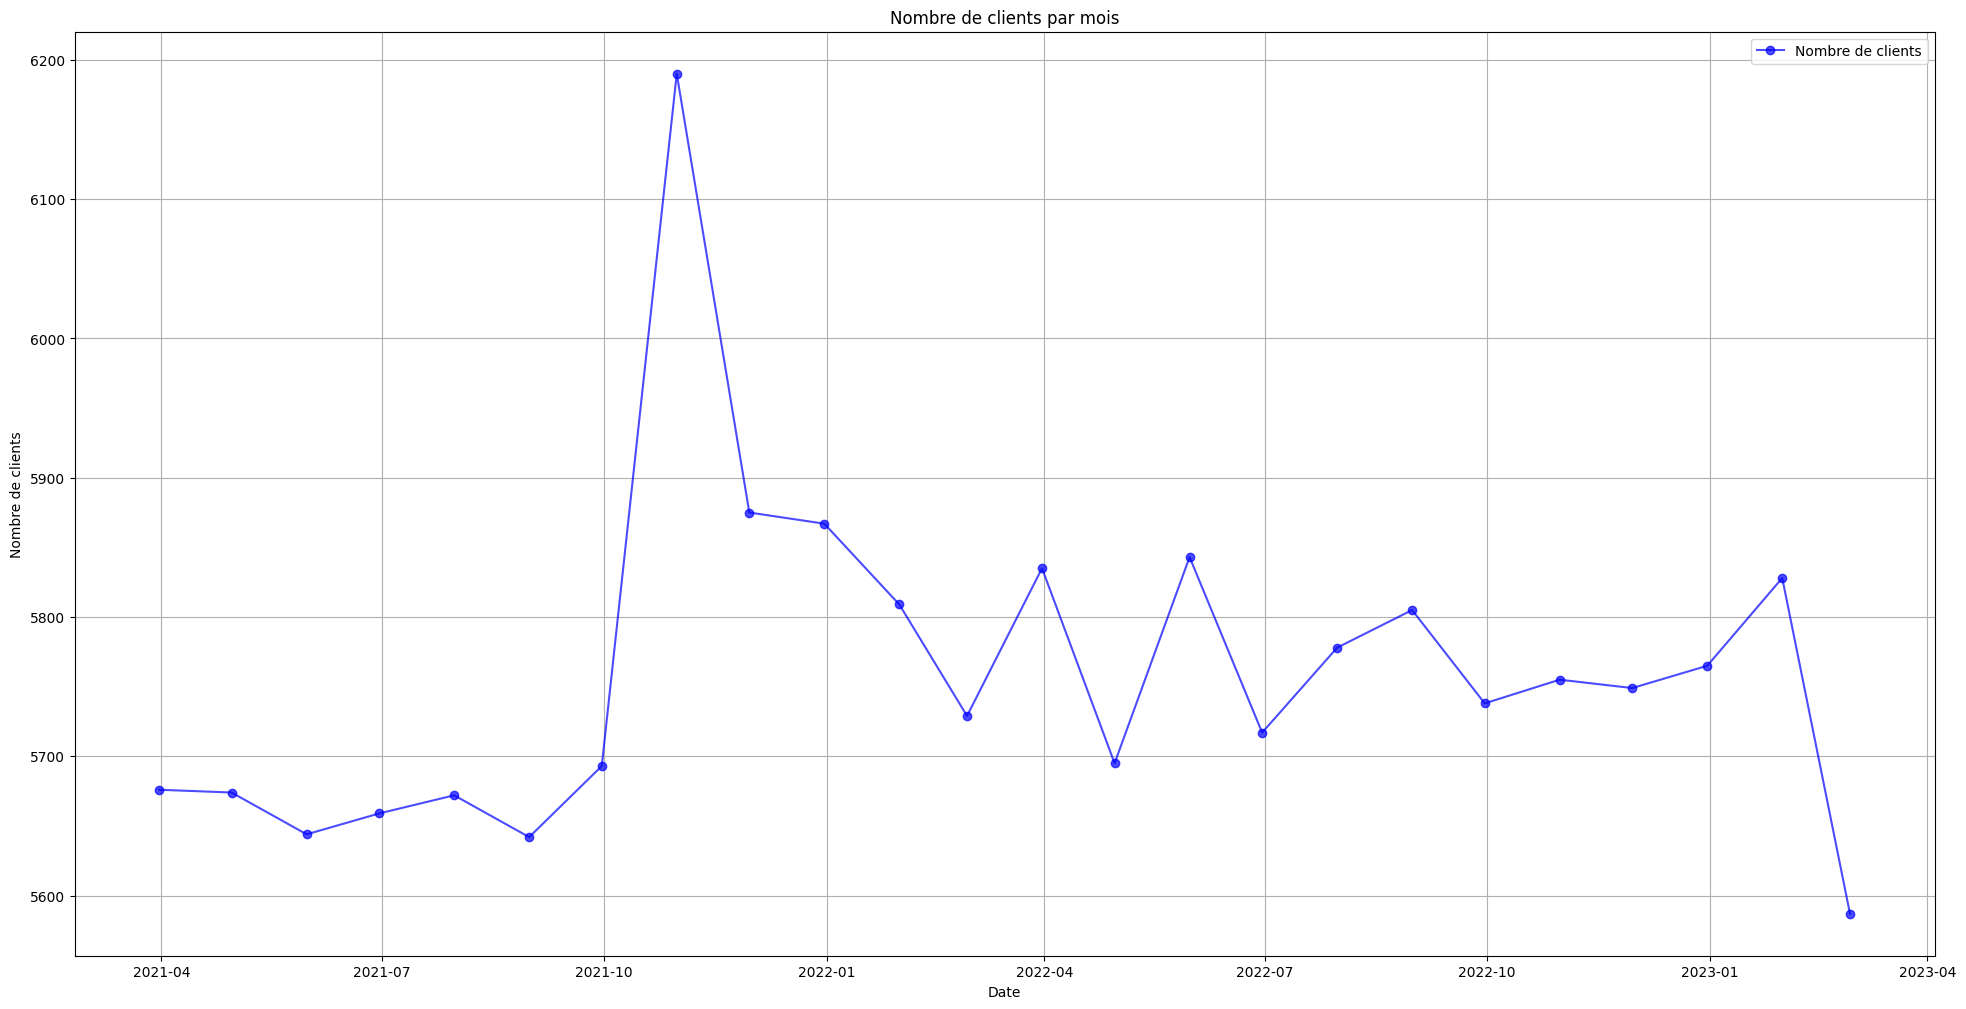

In [29]:
plt.figure(figsize=(24, 12))
plt.plot(nb_client_par_mois.index, nb_client_par_mois, label='Nombre de clients', color='blue', alpha=0.7, marker='o')
plt.xlabel("Date")
plt.ylabel("Nombre de clients")
plt.title("Nombre de clients par mois")
plt.legend()
plt.grid()
plt.show()


pic de clients fin 2021 (période de fete?). Depuis 2022 variation du nombre de clients entre 5700 et 5800 d'un mois sur l'autre

## Evolution du nombre de transactions

In [30]:
nb_transactions_par_mois = df_merge.resample('ME', on='date')['session_id'].nunique()
print(nb_transactions_par_mois)

date
2021-03-31    14201
2021-04-30    13970
2021-05-31    14168
2021-06-30    13838
2021-07-31    13571
2021-08-31    13591
2021-09-30    14848
2021-10-31    14781
2021-11-30    14605
2021-12-31    15566
2022-01-31    14978
2022-02-28    14337
2022-03-31    14826
2022-04-30    14084
2022-05-31    14957
2022-06-30    14389
2022-07-31    14651
2022-08-31    14585
2022-09-30    14263
2022-10-31    14658
2022-11-30    14224
2022-12-31    14634
2023-01-31    14758
2023-02-28    13073
Freq: ME, Name: session_id, dtype: int64


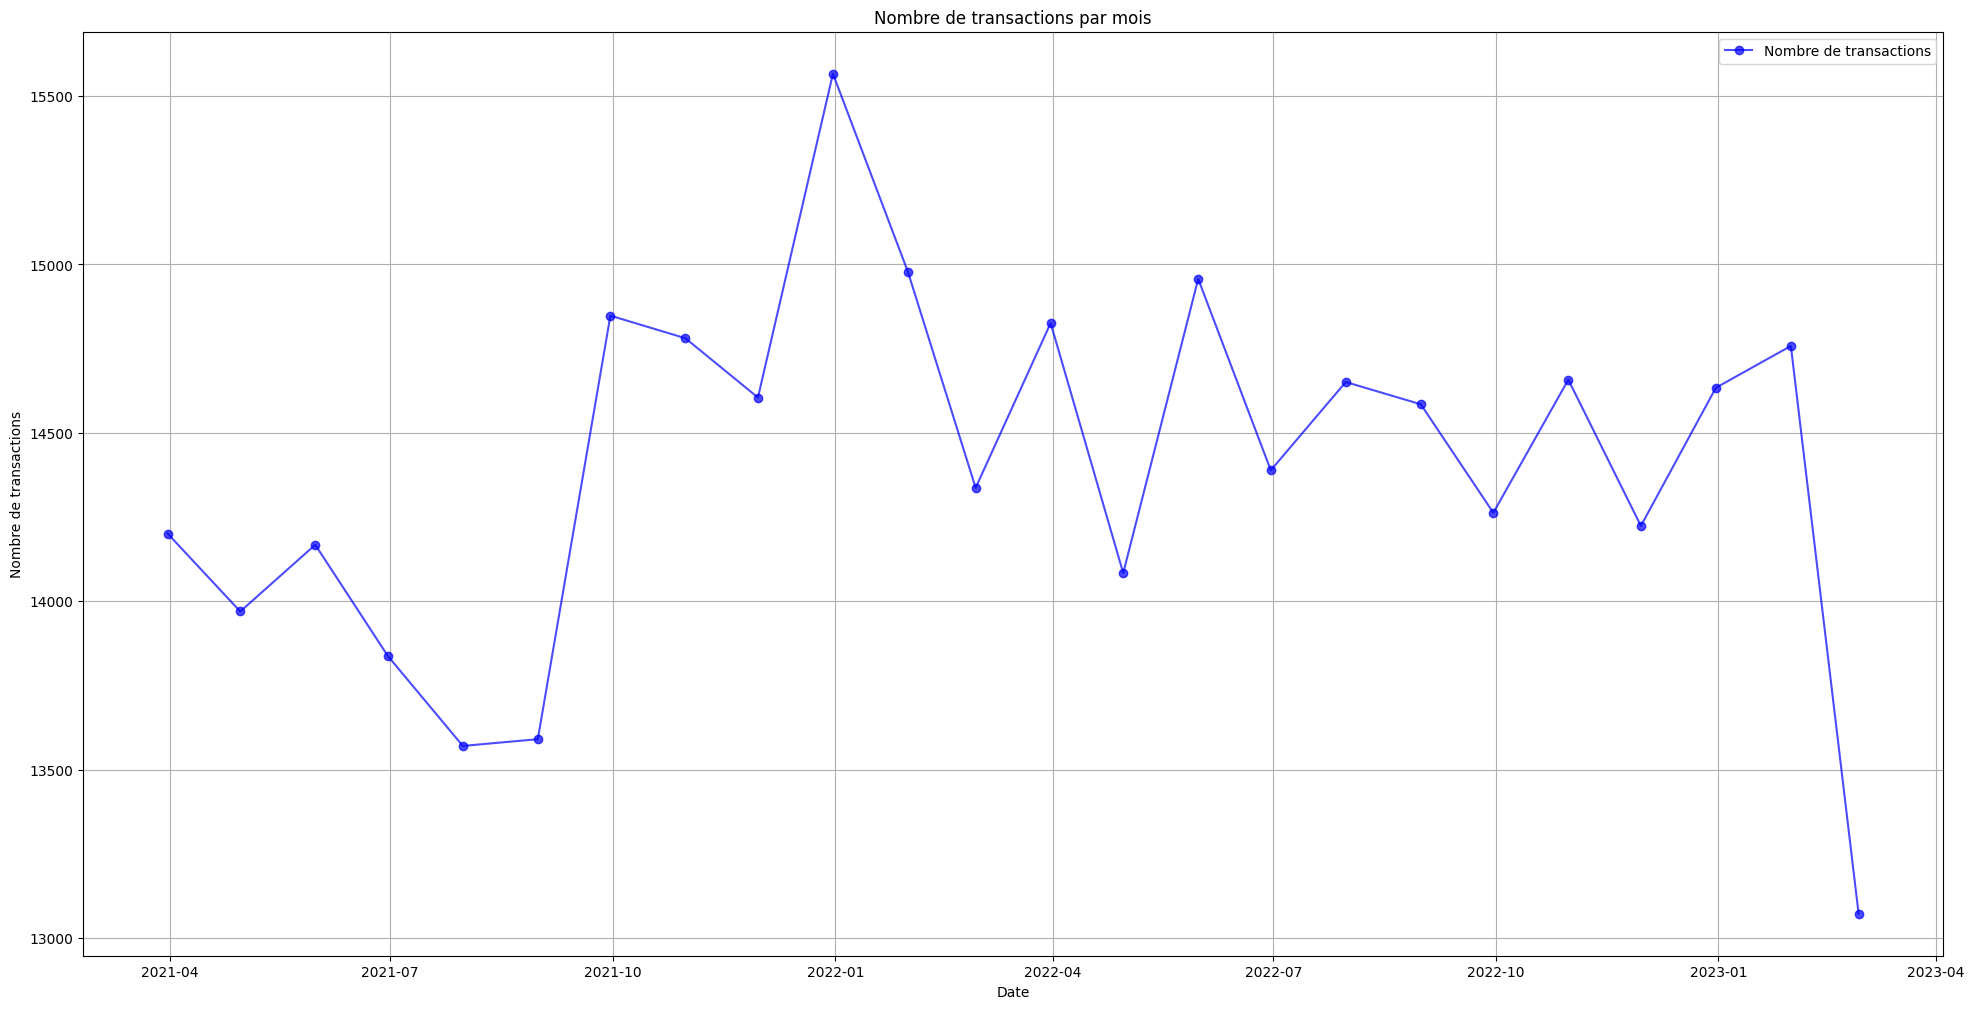

In [31]:
plt.figure(figsize=(24, 12))
plt.plot(nb_transactions_par_mois.index, nb_transactions_par_mois, label='Nombre de transactions', color='blue', alpha=0.7, marker='o')
plt.xlabel("Date")
plt.ylabel("Nombre de transactions")
plt.title("Nombre de transactions par mois")
plt.legend()
plt.grid()
plt.show()

Evolution assez similaire au nombre de client avec un pic du nombre de transaction fin 2021 puis des variations assez importante d'un mois sur l'autre

## Analyse univariée
3 blocs
age sexe
produit : prix moyen par catégorie
top-flop
transaction : ca

### Analyse par AGE

In [32]:
## Calcul de l'age
df_merge['année'] = df_merge['date'].dt.year
df_merge['age'] = 2024 - df_merge['birth']
print(df_merge)

       id_prod                       date session_id client_id sex  birth  \
687533  0_1398 2023-02-28 23:58:30.792755   s_348435    c_3575   f   1981   
687532  0_1547 2023-02-28 23:58:00.107815   s_348447    c_4848   m   1953   
687531   1_695 2023-02-28 23:53:18.929676   s_348446     c_488   f   1985   
687530    2_37 2023-02-28 23:51:29.318531   s_348445      c_50   f   1994   
687529   1_508 2023-02-28 23:49:03.148402   s_348444    c_3573   f   1996   
...        ...                        ...        ...       ...  ..    ...   
4       0_1358 2021-03-01 00:05:18.801198        s_5    c_2033   f   1956   
3       0_1458 2021-03-01 00:04:54.559692        s_4    c_7912   f   1989   
2       0_1352 2021-03-01 00:02:38.311413        s_3     c_580   m   1988   
1       0_1390 2021-03-01 00:02:26.047414        s_2     c_664   m   1960   
0       0_1259 2021-03-01 00:01:07.843138        s_1     c_329   f   1967   

        price  categ  année  age  
687533   4.52      0   2023   43  
68753

In [33]:
## Création des tranches d'âge
df_merge['tranche_age']= pd.cut(df_merge['age'], bins=[0, 20, 30, 40, 50, 60, 130], labels=['-20', '20-30', '30-40', '40-50', '50-60', '+60'])

C:\Users\Pimi\AppData\Local\Temp\ipykernel_49244\1152927303.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  ca_par_age = df_merge.groupby(df_merge['tranche_age'])['price'].sum().round(2)


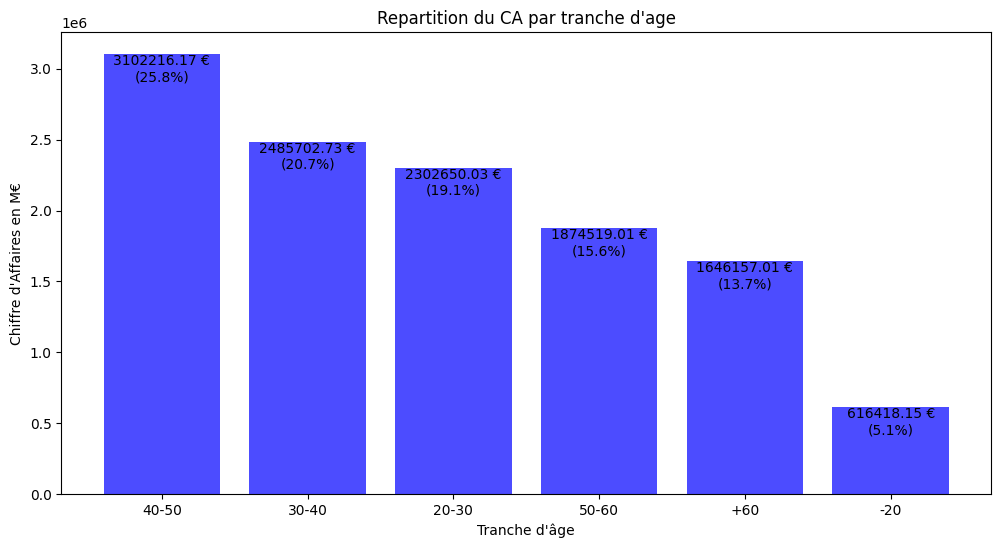

In [34]:
## Chiffre d'affaires par tranche d'âge
ca_par_age = df_merge.groupby(df_merge['tranche_age'])['price'].sum().round(2)

total_ca = ca_par_age.sum()
pourcentage_ca = (ca_par_age / total_ca)*100
pourcentage_sorted = pourcentage_ca.sort_values(ascending=False)
ca_par_age_sorted = ca_par_age.sort_values(ascending=False)

plt.figure(figsize=(12, 6)) ## crée une nouvelle figure pour le graphique figsize définit la taille de la figure en pouces : 12 pouces de large et 6 pouces de haut.
bars = plt.bar(pourcentage_sorted.index, ca_par_age_sorted, color='blue', alpha=0.7) 
for bar, pct in zip(bars, pourcentage_sorted): ##On boucle à la fois sur les barres et les pourcentages et zip(bars, pourcentage_sorted) permet d'associer chaque barre à son pourcentage.
    height = bar.get_height()  # Récupère la hauteur de la barre
    plt.text(bar.get_x() + bar.get_width() / 2, height, 
             f'{height:.2f} €\n({pct:.1f}%)',  # Affiche la valeur + pourcentage
             ha='center', va='top', fontsize=10, color='black')
plt.xlabel("Tranche d'âge")
plt.ylabel("Chiffre d'Affaires en M€")
plt.title("Repartition du CA par tranche d'age")

plt.show()



la clientèle cible: personnes agées de 30-50ans qui représente pratiquement la moitié du CA

### Analyse par Sexe

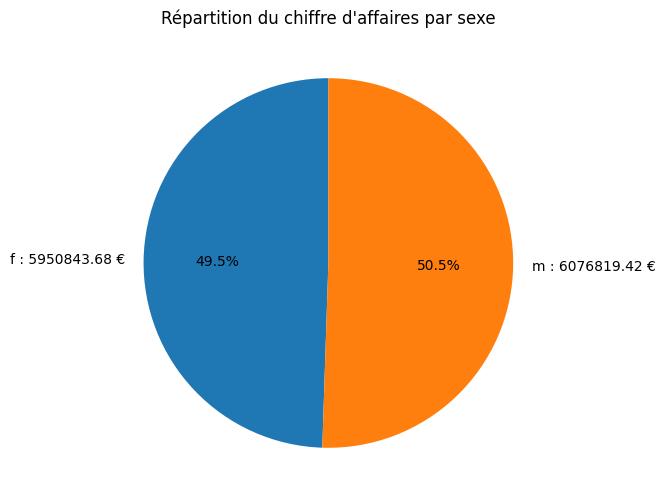

In [35]:
ca_par_sexe = df_merge.groupby(df_merge['sex'])['price'].sum().round(2)

labels = [f'{sexe} : {ca} €' for sexe, ca in zip(ca_par_sexe.index, ca_par_sexe)]
plt.figure(figsize=(12, 6))
plt.pie(ca_par_sexe, labels=labels, autopct='%1.1f%%', startangle=90)
plt.title("Répartition du chiffre d'affaires par sexe")
plt.show()

La clientèle est paritaire entre les femmes et les hommes

### Analyse par produit

Prix moyen par catégorie:
categ
0    10.64
1    20.49
2    76.21
Name: price, dtype: float64

Nombre de ventes par catégorie:
categ
0    415459
1    235592
2     36483
Name: price, dtype: int64

Top 10 des produits les plus vendus:
         nb_ventes  ca_total
id_prod                     
1_369         2340  56136.60
1_417         2269  47626.31
1_414         2246  53522.18
1_498         2202  51460.74
1_425         2163  36749.37
1_403         2040  36699.60
1_413         2036  36627.64
1_412         2014  33533.10
1_406         2003  49694.43
1_407         2001  31995.99


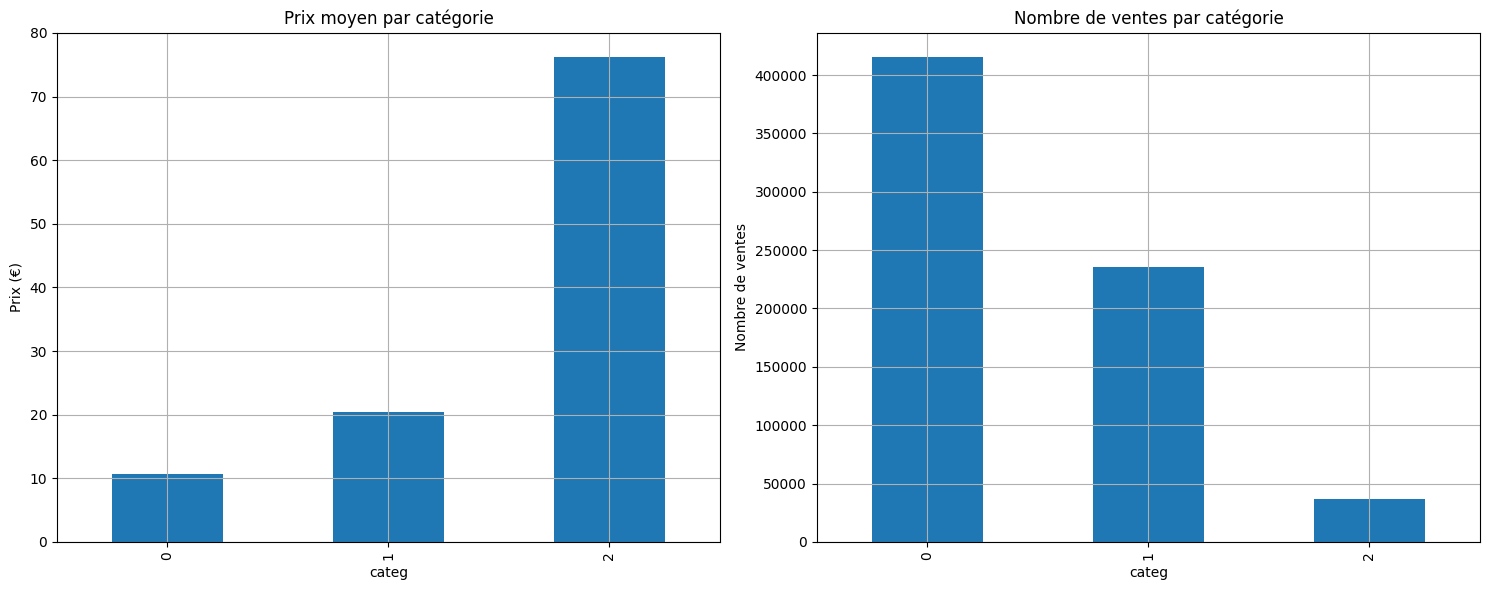

In [36]:
# Prix moyen par catégorie
prix_moyen_cat = df_merge.groupby('categ')['price'].mean().round(2)

# Nombre de ventes par catégorie
nb_ventes_cat = df_merge.groupby('categ')['price'].count()

# Top 10 des produits les plus vendus
top_10_produits = df_merge.groupby('id_prod').agg({
    'price': ['count', 'sum']
}).sort_values(('price', 'count'), ascending=False).head(10)
top_10_produits.columns = ['nb_ventes', 'ca_total']
top_10_produits['ca_total'] = top_10_produits['ca_total'].round(2)

# Affichage des résultats
print("Prix moyen par catégorie:")
print(prix_moyen_cat)
print("\nNombre de ventes par catégorie:")
print(nb_ventes_cat)
print("\nTop 10 des produits les plus vendus:")
print(top_10_produits)

# Visualisation
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Graphique prix moyen par catégorie
prix_moyen_cat.plot(kind='bar', ax=ax1)
ax1.set_title('Prix moyen par catégorie')
ax1.set_ylabel('Prix (€)')
ax1.grid(True)

# Graphique nombre de ventes par catégorie
nb_ventes_cat.plot(kind='bar', ax=ax2)
ax2.set_title('Nombre de ventes par catégorie')
ax2.set_ylabel('Nombre de ventes')
ax2.grid(True)

plt.tight_layout()
plt.show()

La categorie 0 represente les produits les moins chère (11€ en moyenne) et sont les plus vendus (+400K produits vendus)
A contrario la catégorie 2 represente les produits les plus onéreux (76€ en moyenne) et sont les moins vendus (<50K produits vendus)

<Axes: title={'center': 'Flop 20 des produits en CA'}, ylabel='id_prod'>

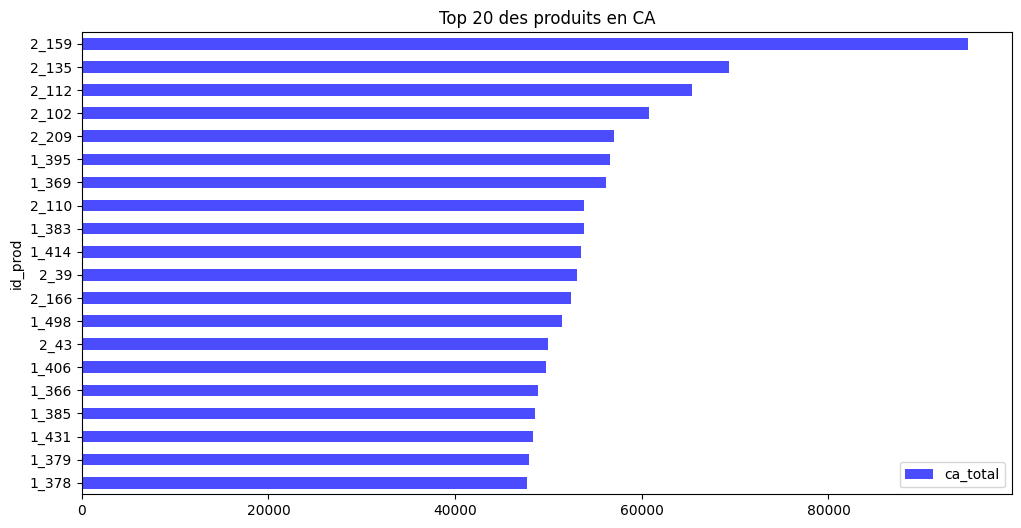

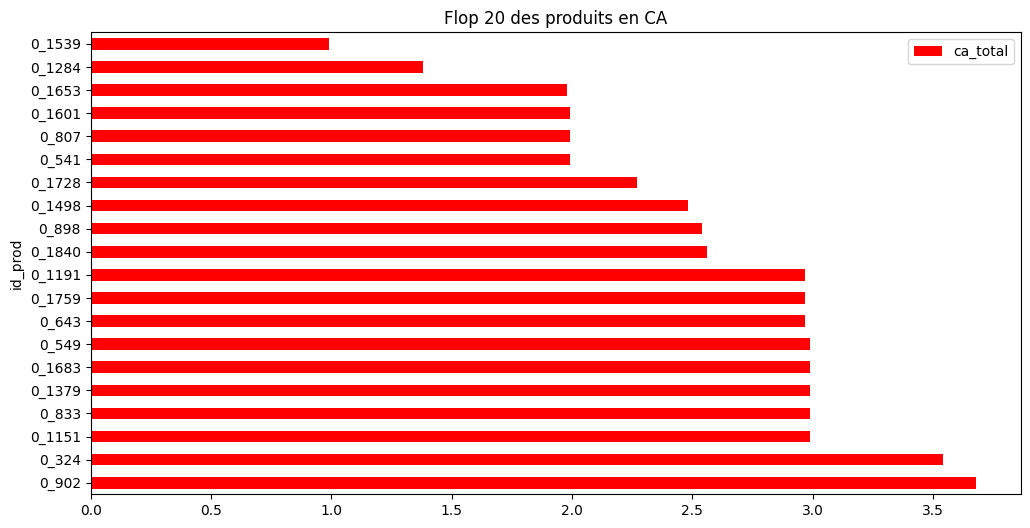

In [37]:
## TOP FLOP des produits
produit_ca = df_merge.groupby('id_prod').agg({'price': ['count', 'sum']}).sort_values(('price', 'count'), ascending=False)
df_produit_ca = produit_ca.reset_index()
df_produit_ca.columns = ['id_prod', 'nb_ventes', 'ca_total']
top20 = df_produit_ca.sort_values(by='ca_total', ascending=True)
top20.tail(20).plot(kind='barh', x='id_prod', y='ca_total', figsize=(12, 6), color='blue', alpha=0.7, title='Top 20 des produits en CA')
flop20 = df_produit_ca.sort_values(by='ca_total', ascending=False)
flop20.tail(20).plot(kind='barh', x='id_prod', y='ca_total', figsize=(12, 6), color='red', alpha=1, title='Flop 20 des produits en CA')

<Axes: title={'center': 'Flop 20 des produits en nombre de ventes'}, ylabel='id_prod'>

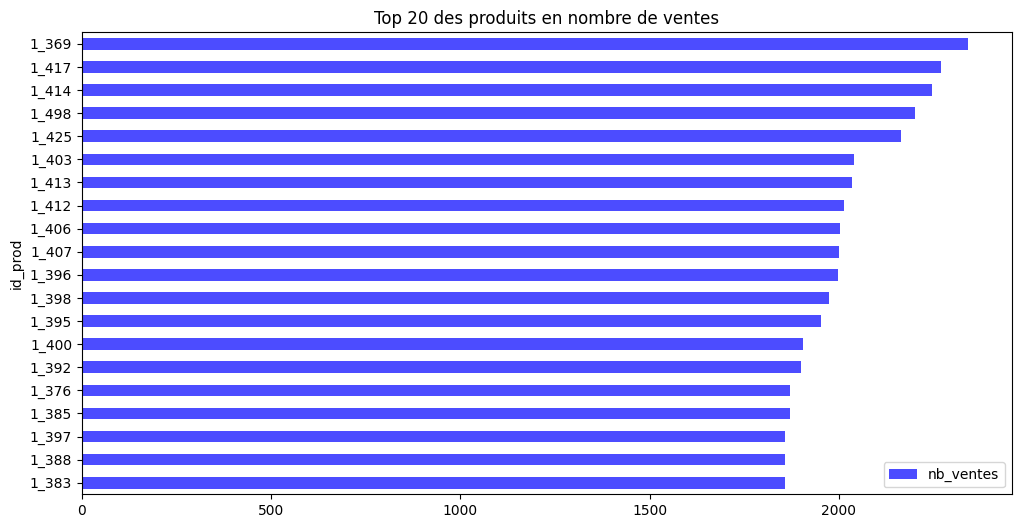

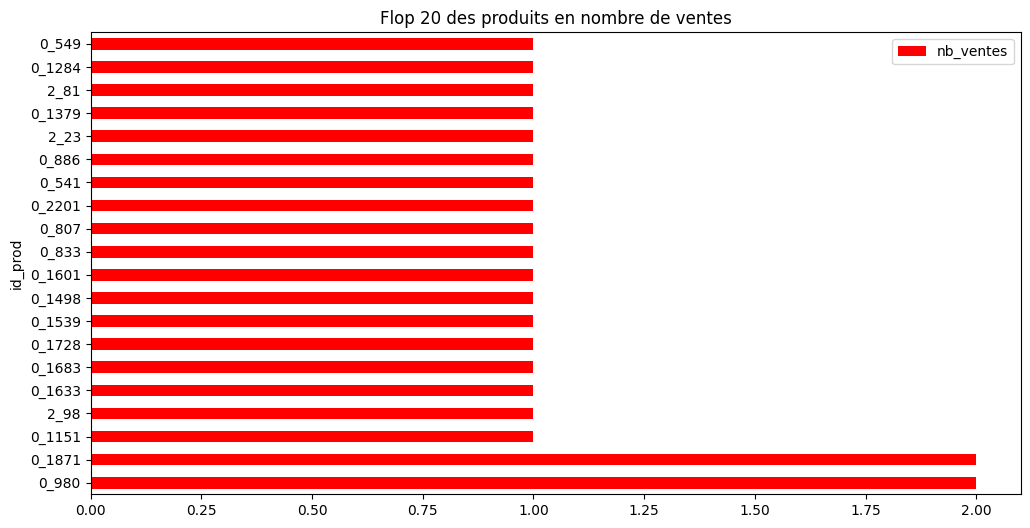

In [38]:
top20_nb_vente = df_produit_ca.sort_values(by='nb_ventes', ascending=True)
top20_nb_vente.tail(20).plot(kind='barh', x='id_prod', y='nb_ventes', figsize=(12, 6), color='blue', alpha=0.7, title='Top 20 des produits en nombre de ventes')
flop20_nb_vente = df_produit_ca.sort_values(by='nb_ventes', ascending=False)
flop20_nb_vente.tail(20).plot(kind='barh', x='id_prod', y='nb_ventes', figsize=(12, 6), color='red', alpha=1, title='Flop 20 des produits en nombre de ventes')

parler des catégories representées dans les differents tops/flops

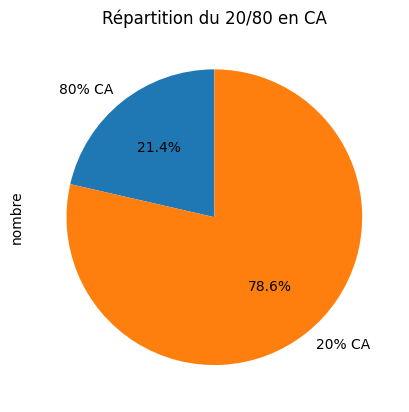

la régle des 20/80 est globalement respectée puisque 21.41% des produits génèrent 80% du chiffre d'affaire


In [39]:
# Calcul du 20 / 80 en CA

df_produit_ca['part_ca'] = df_produit_ca['ca_total'] / chiffre_affaire
df_produit_ca.sort_values(by='part_ca', ascending=False, inplace=True)
df_produit_ca['part_ca_cumul'] = df_produit_ca['part_ca'].cumsum()
df_produit_80_ca = df_produit_ca[df_produit_ca['part_ca_cumul'] <= 0.8]

resultat = round(df_produit_80_ca.shape[0]/df_produit_ca.shape[0]*100,2)
nb_produit_80_ca = df_produit_80_ca.shape[0]
nb_produit = df_produit_ca.shape[0]
df_proportion = pd.DataFrame({'categories': ['80% CA', '20% CA'], 'nombre': [nb_produit_80_ca / nb_produit, 1-(nb_produit_80_ca / nb_produit)]})
df_proportion.plot(kind='pie', y='nombre', labels=df_proportion['categories'], autopct='%1.1f%%', startangle=90, legend=False)
plt.title('Répartition du 20/80 en CA')
plt.show()
print (f"la régle des 20/80 est globalement respectée puisque {resultat}% des produits génèrent 80% du chiffre d'affaire")


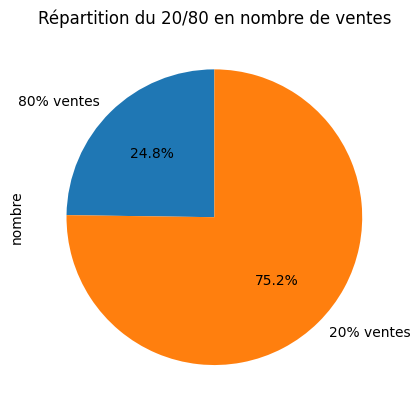

la régle des 20/80 est globalement respectée puisque 24.78% des produits génèrent 80% des ventes


In [40]:
# Calcul du 20 / 80 en nombre de ventes
df_produit_ca['part_ventes'] = df_produit_ca['nb_ventes'] / df_produit_ca['nb_ventes'].sum()
df_produit_ca.sort_values(by='part_ventes', ascending=False, inplace=True)
df_produit_ca['part_ventes_cumul'] = df_produit_ca['part_ventes'].cumsum()
df_produit_80_ventes = df_produit_ca[df_produit_ca['part_ventes_cumul'] <= 0.8]
resultat = round(df_produit_80_ventes.shape[0]/df_produit_ca.shape[0]*100,2)
nb_produit_80_ventes = df_produit_80_ventes.shape[0]
nb_produit = df_produit_ca.shape[0]
df_proportion = pd.DataFrame({'categories': ['80% ventes', '20% ventes'], 'nombre': [nb_produit_80_ventes / nb_produit, 1-(nb_produit_80_ventes / nb_produit)]})
df_proportion.plot(kind='pie', y='nombre', labels=df_proportion['categories'], autopct='%1.1f%%', startangle=90, legend=False)
plt.title('Répartition du 20/80 en nombre de ventes')
plt.show()
print (f"la régle des 20/80 est globalement respectée puisque {resultat}% des produits génèrent 80% des ventes")



### Analyse par client

In [41]:
# Top 10 des clients représentant le plus de CA :
clients_ca = df_merge.groupby('client_id')['price'].sum().sort_values(ascending=False)
df_client_ca = clients_ca.reset_index()
df_client_ca.columns = ['client_id', 'ca']
df_client_ca['part_ca'] = (df_client_ca['ca'] / chiffre_affaire * 100).round(4)

print(df_client_ca.head(10))


  client_id         ca  part_ca
0    c_1609  326039.89   2.7108
1    c_4958  290227.03   2.4130
2    c_6714  153918.60   1.2797
3    c_3454  114110.57   0.9487
4    c_1570    5285.82   0.0439
5    c_3263    5276.87   0.0439
6    c_2140    5260.18   0.0437
7    c_2899    5214.05   0.0434
8    c_7319    5155.77   0.0429
9    c_7959    5135.75   0.0427


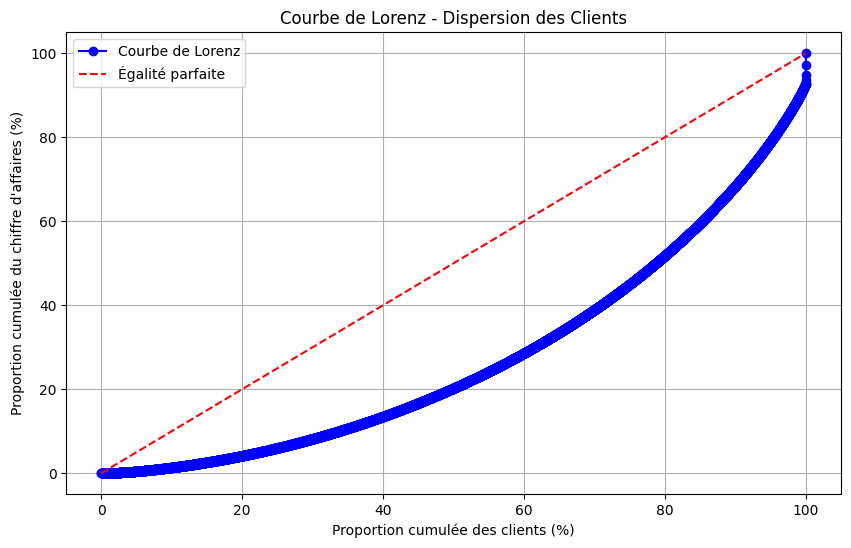

L'indice de Gini est de 0.4418958724711329


In [42]:
### Dispersion des clients :


# Calcul du ca total par client
ca_par_client = df_merge.groupby('client_id')['price'].sum().sort_values()

# Calcul de la contribution cumulée des clients au chiffre d'affaires
ca_cumule = ca_par_client.cumsum()
total_ca = ca_par_client.sum()
pourcentage_ca_cumule = ca_cumule / total_ca * 100

# Calcul de la proportion cumulée des clients
pourcentage_clients_cumule = np.arange(1, len(ca_par_client) + 1) / len(ca_par_client) * 100

# Courbe de Lorenz
plt.figure(figsize=(10, 6))
plt.plot(pourcentage_clients_cumule, pourcentage_ca_cumule, marker='o', linestyle='-', color='b', label='Courbe de Lorenz')
plt.plot(pourcentage_clients_cumule, pourcentage_clients_cumule, linestyle='--', color='r', label='Égalité parfaite')

plt.xlabel('Proportion cumulée des clients (%)')
plt.ylabel('Proportion cumulée du chiffre d\'affaires (%)')
plt.title('Courbe de Lorenz - Dispersion des Clients')
plt.legend()
plt.grid(True)
plt.show()

#calcul de l'indice de gini
aire_sous_courbe = np.trapezoid(pourcentage_ca_cumule, pourcentage_clients_cumule)
aire_sous_diagonale = np.trapezoid(pourcentage_clients_cumule, pourcentage_clients_cumule)
indice_gini = (aire_sous_diagonale - aire_sous_courbe) / aire_sous_diagonale
print("L'indice de Gini est de", indice_gini)



Forte inégalité dans la contribution des clients aux ca. 20% des clients les moins contributifs représente 5% du CA. 20% des clients les plus contributifs réprésente 50% du CA.
Risque : Dépendance à cette minorité de client
opportunité : fidéliser les autres clients pour diminuer le risque



In [43]:
## analyse en excluant les 4 gros clients

df_client_ca_filtered = df_client_ca.iloc[4:]
df_client_ca_filtered = df_client_ca_filtered.copy() # On crée une copie pour éviter de modifier le DataFrame initial
chiffre_affaire_filtered = df_client_ca_filtered['ca'].sum()
df_client_ca_filtered['part_ca'] = (df_client_ca_filtered['ca'] / chiffre_affaire_filtered * 100).round(4)
print(df_client_ca_filtered.head(10))

   client_id       ca  part_ca
4     c_1570  5285.82   0.0474
5     c_3263  5276.87   0.0474
6     c_2140  5260.18   0.0472
7     c_2899  5214.05   0.0468
8     c_7319  5155.77   0.0463
9     c_7959  5135.75   0.0461
10    c_1422  5131.36   0.0460
11    c_7421  5097.18   0.0457
12    c_8026  5082.58   0.0456
13    c_2505  5059.35   0.0454


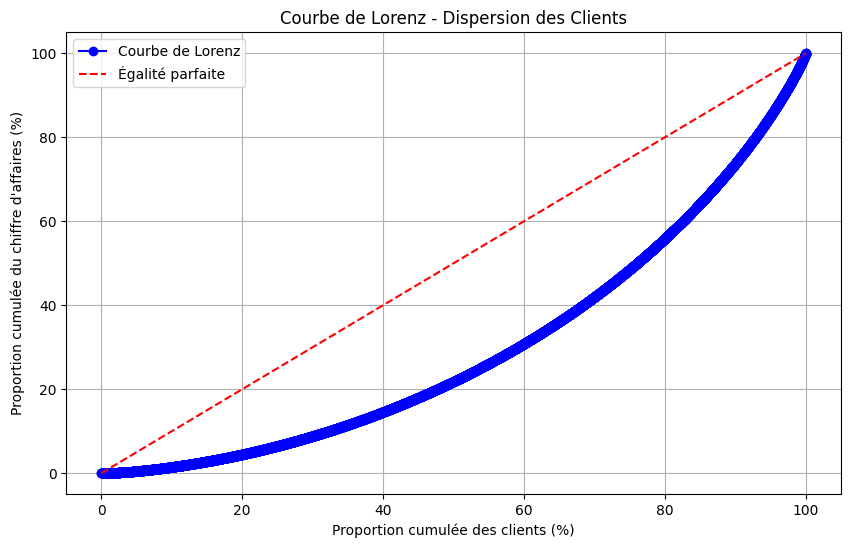

L'indice de Gini est de : 0.39828602699719956


In [44]:
ca_par_client_filtered = df_merge[df_merge['client_id'].isin(df_client_ca_filtered['client_id'])].groupby('client_id')['price'].sum().sort_values()
ca_cumule_filtered = ca_par_client_filtered.cumsum()
total_ca_filtered = ca_par_client_filtered.sum()
pourcentage_ca_cumule_filtered = ca_cumule_filtered / total_ca_filtered * 100
pourcentage_clients_cumule_filtered = np.arange(1, len(ca_par_client_filtered) + 1) / len(ca_par_client_filtered) * 100
#courbe de lorenz
plt.figure(figsize=(10, 6))
plt.plot(pourcentage_clients_cumule_filtered, pourcentage_ca_cumule_filtered, marker='o', linestyle='-', color='b', label='Courbe de Lorenz')
plt.plot(pourcentage_clients_cumule_filtered, pourcentage_clients_cumule_filtered, linestyle='--', color='r', label='Égalité parfaite')

plt.xlabel('Proportion cumulée des clients (%)')
plt.ylabel('Proportion cumulée du chiffre d\'affaires (%)')
plt.title('Courbe de Lorenz - Dispersion des Clients')
plt.legend()
plt.grid(True)
plt.show()
#calcul de l'indice de gini
aire_sous_courbe = np.trapezoid(pourcentage_ca_cumule_filtered, pourcentage_clients_cumule_filtered)
aire_sous_diagonale = np.trapezoid(pourcentage_clients_cumule_filtered, pourcentage_clients_cumule_filtered)
indice_gini = (aire_sous_diagonale - aire_sous_courbe) / aire_sous_diagonale
print("L'indice de Gini est de :", indice_gini)




En excluant les 4 plus gros clients, on observe une baisse de l'indice de Gini (0,44 à 0,39). Cela signifie que ces 4 clients ayant un ca disproportionnellement élevée par rapport aux autres augmentait l'inégalité globale dans la distribution du ca.
La 2eme courbe de lorenz permet d'avoir une visualisation plus representative de la majorité des clients 

In [45]:
## exclusion des 4 clients BtoB
clients_btob = ["c_1609", "c_4958", "c_6714", "c_3454"]
df_merge_filtered = df_merge[~df_merge['client_id'].isin(clients_btob)]
df_merge_filtered.shape[0]



640734

# Corrélations

## Corrélation entre le genre d'un client et les catégories des livres achetés
 quali / quali tableau 2x2 on utilise le test de fisher et 2x3 ou plus le Chi2

In [46]:
### NEW
df_cor_genre = df_merge_filtered.copy()


In [47]:
df_cor_genre.head()

,id_prod,date,session_id,client_id,sex,birth,price,categ,année,age,tranche_age
687533,0_1398,2023-02-28 23:58:30.792755,s_348435,c_3575,f,1981,4.52,0,2023,43,40-50
687532,0_1547,2023-02-28 23:58:00.107815,s_348447,c_4848,m,1953,8.99,0,2023,71,+60
687531,1_695,2023-02-28 23:53:18.929676,s_348446,c_488,f,1985,26.99,1,2023,39,30-40
687530,2_37,2023-02-28 23:51:29.318531,s_348445,c_50,f,1994,48.99,2,2023,30,20-30
687529,1_508,2023-02-28 23:49:03.148402,s_348444,c_3573,f,1996,21.92,1,2023,28,20-30


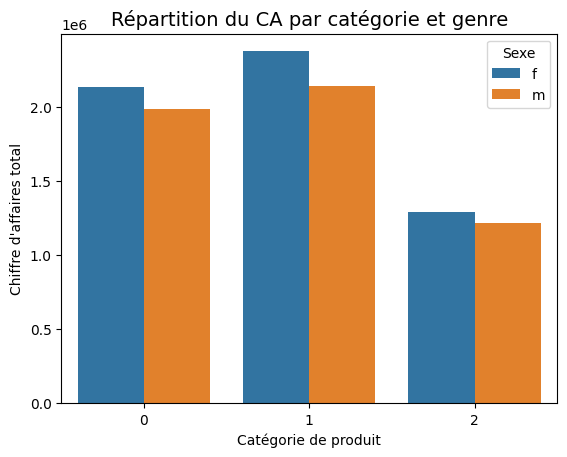

In [48]:
sns.barplot(
    data=df_cor_genre, 
    x='categ', 
    y='price', 
    hue="sex", 
    estimator=sum,      
    errorbar=None
)

plt.title("Répartition du CA par catégorie et genre", fontsize=14)  
plt.xlabel("Catégorie de produit")  
plt.ylabel("Chiffre d'affaires total")  
plt.legend(title="Sexe")
plt.show()

In [49]:

## Test de chi2
contingency_table = pd.crosstab(df_cor_genre['sex'], df_cor_genre['categ']) ## tableau croisé qui compte le nombre d'achats par genre et par catégorie
print(contingency_table)

chi2_stat, p_value, dof, expected = chi2_contingency(contingency_table) ## applique le test du Chi2 sur le tableau croisé
chi2_stat = round(chi2_stat, 0)
p_value_genre = p_value
expected = expected.round(0)

print(f"Statistique du test du Chi2 : {chi2_stat}") ## affiche la statistique du test du Chi2
print(f"P-value : {p_value_genre}")
print(f"Degrés de liberté : {dof}")
print("Tableau des valeurs attendues :")
print(expected)



categ       0       1      2
sex                         
f      200793  115721  16980
m      186488  104884  15868
Statistique du test du Chi2 : 23.0
P-value : 1.1955928116587024e-05
Degrés de liberté : 2
Tableau des valeurs attendues :
[[201575. 114822.  17097.]
 [185706. 105783.  15751.]]


La p-value est inférieure à 0.05, on rejette donc l'hypothèse nulle et on peut conclure que le genre du client et la catégorie du produit acheté sont liés.

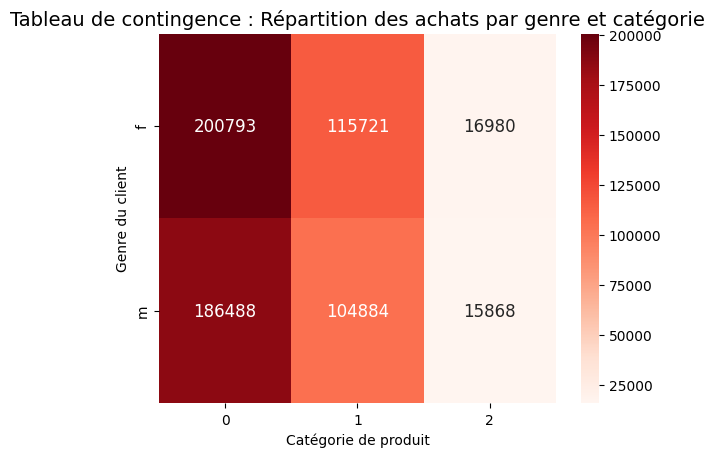

In [50]:
sns.heatmap(
    contingency_table, 
    annot=True, 
    cmap="Reds", 
    fmt="d",  # Affichage sous forme d'entiers
    annot_kws={"size": 12}  # Ajuste la taille des annotations pour lisibilité
)
plt.title("Tableau de contingence : Répartition des achats par genre et catégorie", fontsize=14)  
plt.xlabel("Catégorie de produit")  
plt.ylabel("Genre du client")   
plt.show()

les femmes réalisent plus d'achats dans toutes les catégories que les hommes 

## Corrélation entre l'age des clients et le montant total des achats
quanti / quanti

In [51]:
df_merge_filtered.head()

,id_prod,date,session_id,client_id,sex,birth,price,categ,année,age,tranche_age
687533,0_1398,2023-02-28 23:58:30.792755,s_348435,c_3575,f,1981,4.52,0,2023,43,40-50
687532,0_1547,2023-02-28 23:58:00.107815,s_348447,c_4848,m,1953,8.99,0,2023,71,+60
687531,1_695,2023-02-28 23:53:18.929676,s_348446,c_488,f,1985,26.99,1,2023,39,30-40
687530,2_37,2023-02-28 23:51:29.318531,s_348445,c_50,f,1994,48.99,2,2023,30,20-30
687529,1_508,2023-02-28 23:49:03.148402,s_348444,c_3573,f,1996,21.92,1,2023,28,20-30


In [52]:
df_merge_filtered.shape[0]

640734

In [53]:
df_cor_total_achat = df_merge_filtered.copy()

In [54]:


# Calcul du CA total par age
df_cor_total_achat =df_cor_total_achat.groupby('age')['price'].sum().reset_index()


# Renommer la colonne
##df_cor_total_achat.rename(columns={'price': 'ca_total_par_client'}, inplace=True)

# Vérification
print(df_cor_total_achat.head())

   age      price
0   20  616418.15
1   21  180680.89
2   22  186791.83
3   23  181233.57
4   24  167388.08


In [55]:
df_cor_total_achat.shape[0]

76

In [56]:


# Test de normalité pour l'âge
stat, p_age = shapiro(df_cor_total_achat['age'])
print(f"Test de Shapiro-Wilk pour l'âge : p-value = {p_age}")

# Test de normalité pour le CA total par age
stat, p_ca = shapiro(df_cor_total_achat['price'])
print(f"Test de Shapiro-Wilk pour le CA total : p-value = {p_ca}")

Test de Shapiro-Wilk pour l'âge : p-value = 0.008752885621051844
Test de Shapiro-Wilk pour le CA total : p-value = 6.473609171793038e-05


la p-value est < 0.05 donc j'utilise le test de correlation de spearman

In [57]:
# Test de Spearman entre âge et montant total des achats par client
corr_achat, p_value_achat = spearmanr(df_cor_total_achat['age'], df_cor_total_achat['price'])

print(f"Corrélation de Spearman : {corr_achat}, p-value : {p_value_achat}")

Corrélation de Spearman : -0.8744497607655503, p-value : 5.956077505475151e-25


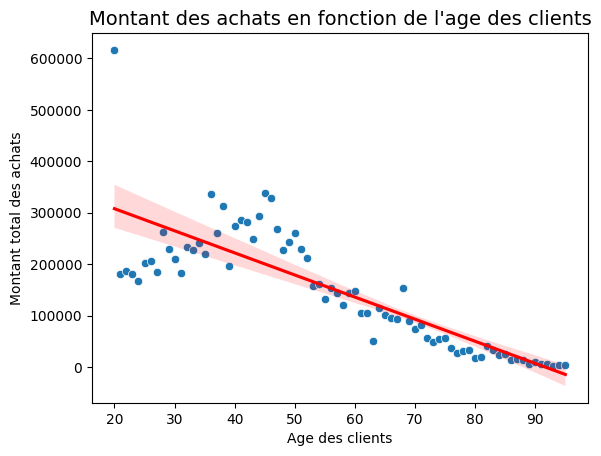

In [58]:
sns.scatterplot(data=df_cor_total_achat, x='age', y='price')
sns.regplot(data=df_cor_total_achat, x='age', y='price', scatter=False, color='red', label="Tendance")
plt.title("Montant des achats en fonction de l'age des clients", fontsize=14)  
plt.ylabel("Montant total des achats")  
plt.xlabel("Age des clients")   
plt.show()

Il y a bien une correlation négative modérée (-0,87) entre l'age des clients et le montant total du CA :
Quand l'age augmente, le montant total du CA diminue.

## Corrélation entre l'age des clients et la frequence d'achat
quanti / quanti

In [59]:
df_cor_frequence_achat = df_merge_filtered.copy()

In [60]:
# Calcul du nombre de sessions par client
df_sessions_par_client = df_cor_frequence_achat.groupby(['client_id', 'age'])['session_id'].nunique().reset_index()

# Calcul de la moyenne du nombre de sessions par âge
df_cor_frequence_achat = df_sessions_par_client.groupby('age')['session_id'].mean().reset_index().rename(
    columns={'session_id': 'nb_session_moyen'}
)
# Vérification
print(df_cor_frequence_achat.head())

   age  nb_session_moyen
0   20         20.036613
1   21         18.034483
2   22         18.386207
3   23         19.904000
4   24         18.205882


In [61]:
# Test de normalité pour la fréquence d'achat par age
stat, p_achat = shapiro(df_cor_frequence_achat['nb_session_moyen'])
print(f"Test de Shapiro-Wilk pour la fréquence d'achat par age des clients: p-value = {p_achat}")

Test de Shapiro-Wilk pour la fréquence d'achat par age des clients: p-value = 0.0006182225372292466


In [62]:
# Test de Spearman entre l'âge et le nombre d'achats
corr_nb_achat, p_value_nb_achat = spearmanr(df_cor_frequence_achat['age'], df_cor_frequence_achat['nb_session_moyen'])
print(f"Corrélation de Spearman : {corr_nb_achat}, p-value : {p_value_nb_achat:}")

Corrélation de Spearman : -0.003144245688697435, p-value : 0.978494293789479


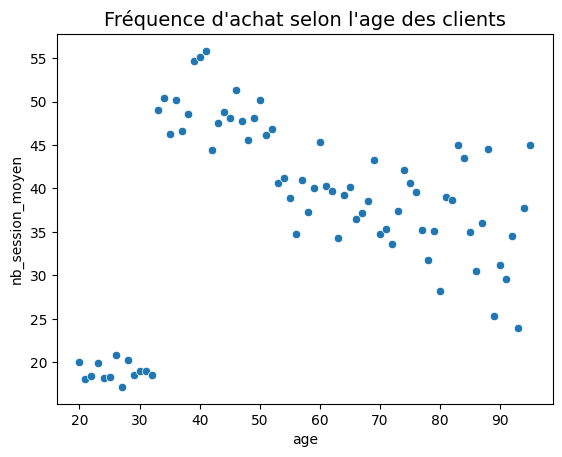

In [63]:
sns.scatterplot(data=df_cor_frequence_achat, x='age', y='nb_session_moyen')
plt.title("Fréquence d'achat selon l'age des clients", fontsize=14)  
plt.show()

Selon la p-value, la corrélation n'est pas significative (on ne peut pas conclure à une vraie relation). En réalité nous voyons qu'il y a une fréquence d'achat relativement faible pour les plus jeunes. A partir de 30-40ans les clients achètent très souvent et plus on avance dans les tranches d'age supérieur et plus la fréquence d'achat diminue.

## Corrélation entre l'age des clients et la taille du panier moyen
quanti / quanti nuage de point

In [64]:

df_cor_panier_moyen = df_merge_filtered.copy()  # Créer une copie indépendante


In [65]:
## Ajout du panier moyen par client
df_cor_panier_moyen['panier_moyen_age'] = df_cor_panier_moyen.groupby('age')['price'].transform('mean')
df_cor_panier_moyen.head(10)

,id_prod,date,session_id,client_id,sex,birth,price,categ,année,age,tranche_age,panier_moyen_age
687533,0_1398,2023-02-28 23:58:30.792755,s_348435,c_3575,f,1981,4.52,0,2023,43,40-50,13.352637
687532,0_1547,2023-02-28 23:58:00.107815,s_348447,c_4848,m,1953,8.99,0,2023,71,+60,16.421348
687531,1_695,2023-02-28 23:53:18.929676,s_348446,c_488,f,1985,26.99,1,2023,39,30-40,13.297888
687530,2_37,2023-02-28 23:51:29.318531,s_348445,c_50,f,1994,48.99,2,2023,30,20-30,39.540119
687529,1_508,2023-02-28 23:49:03.148402,s_348444,c_3573,f,1996,21.92,1,2023,28,20-30,42.434323
687528,1_366,2023-02-28 23:48:53.349647,s_348443,c_4999,f,1972,28.54,1,2023,52,50-60,13.370291
687527,0_998,2023-02-28 23:47:05.145663,s_348427,c_4476,f,1977,9.41,0,2023,47,40-50,13.240892
687526,1_551,2023-02-28 23:45:54.822218,s_348442,c_7932,f,1980,14.99,1,2023,44,40-50,13.278478
687525,1_417,2023-02-28 23:45:54.817107,s_348438,c_7144,f,1984,20.99,1,2023,40,30-40,13.301348
687524,0_1039,2023-02-28 23:43:05.079569,s_348438,c_7144,f,1984,11.99,0,2023,40,30-40,13.301348


In [66]:
## Test de normalité pour le panier moyen par client
stat, p_panier = shapiro(df_cor_panier_moyen['panier_moyen_age'])
print(f"Test de Shapiro-Wilk pour le panier moyen par age : p-value = {p_panier}")
##print(stat)

Test de Shapiro-Wilk pour le panier moyen par age : p-value = 9.399519154876906e-203


c:\Users\Pimi\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 640734.
  res = hypotest_fun_out(*samples, **kwds)


 la p-value étant < 0,05 on utilise le test de spearman

In [67]:
## test de correlation entre l'age et le panier moyen
corr_panier, p_value_panier = spearmanr(df_cor_panier_moyen['age'], df_cor_panier_moyen['panier_moyen_age'])
print(f"Corrélation de Spearman : {corr_panier}, p-value : {p_value_panier}")

Corrélation de Spearman : 0.1225761974335297, p-value : 0.0


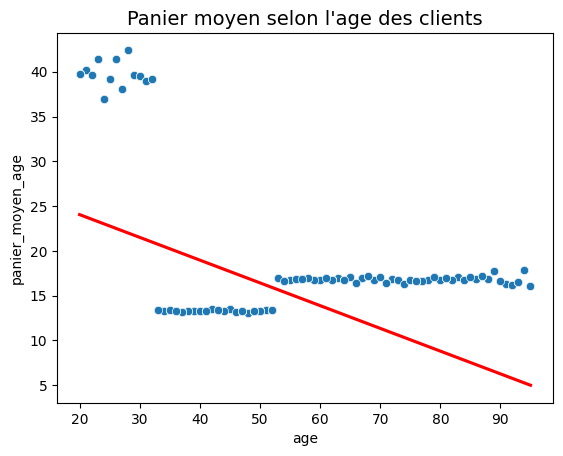

In [68]:
sns.scatterplot(data=df_cor_panier_moyen, x='age', y='panier_moyen_age')
sns.regplot(data=df_cor_panier_moyen, x='age', y='panier_moyen_age', scatter=False, color='red', label="Tendance")
plt.title("Panier moyen selon l'age des clients", fontsize=14)   
plt.show()

On note un paradoxe ici car la correlation est légérement positive et la tendance est négative

La forte présence des 30-50 ans, qui ont un panier moyen très bas, tire visuellement la tendance vers le bas.
Cependant, la corrélation est influencée par les jeunes et les seniors, qui ont un panier moyen plus élevé, ce qui compense la tendance décroissante globale et produit un coefficient de correlation légèrement positif.

Le panier moyen n’évolue pas de manière strictement monotone avec l’âge.
Les 30-50 ans, majoritaires, ont un panier plus faible, ce qui masque partiellement l’effet des jeunes et des seniors.

## Corrélation entre l'age des clients et la catégorie des livres achetés
 quanti / quali

In [69]:
df_corr_categorie = df_merge_filtered.copy()  # Créer une copie

In [70]:
df_corr_categorie['categ'].value_counts()

categ
0    387281
1    220605
2     32848
Name: count, dtype: int64

la categorie 2 est sous représentée

In [71]:
for cat in df_corr_categorie['categ'].unique():
    stat, p_value_categ = shapiro(df_corr_categorie[df_corr_categorie['categ'] == cat]['age'])
    print(f"Catégorie {cat} - p-value du test de Shapiro-Wilk : {p_value_categ}")

Catégorie 0 - p-value du test de Shapiro-Wilk : 8.707643406957955e-127
Catégorie 1 - p-value du test de Shapiro-Wilk : 2.5454248642582885e-73
Catégorie 2 - p-value du test de Shapiro-Wilk : 6.035480713338905e-118


c:\Users\Pimi\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 387281.
  res = hypotest_fun_out(*samples, **kwds)
c:\Users\Pimi\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 220605.
  res = hypotest_fun_out(*samples, **kwds)
c:\Users\Pimi\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 32848.
  res = hypotest_fun_out(*samples, **kwds)


comme toutes les p-values sont <0,05 et qu'on a plus de 2 valeurs on utilise le test de Kruskal-Wallis

In [72]:


# 1. classe les ages pour chaque catégorie de livre
groupes = [df_corr_categorie[df_corr_categorie['categ'] == cat]['age'] for cat in df_corr_categorie['categ'].unique()]

# 2. Appliquer le test de Kruskal-Wallis
stat, p_value_categ = kruskal(*groupes)

# 3. Afficher les résultats
print(f"Test de Kruskal-Wallis : statistique={stat}, p-value={p_value_categ}")

Test de Kruskal-Wallis : statistique=71359.73412120914, p-value=0.0


p-value < 0,05  : une différence significative entre les distributions des groupes
71359 signifie qu'il y a une difference importantes entre les distributions des groupes

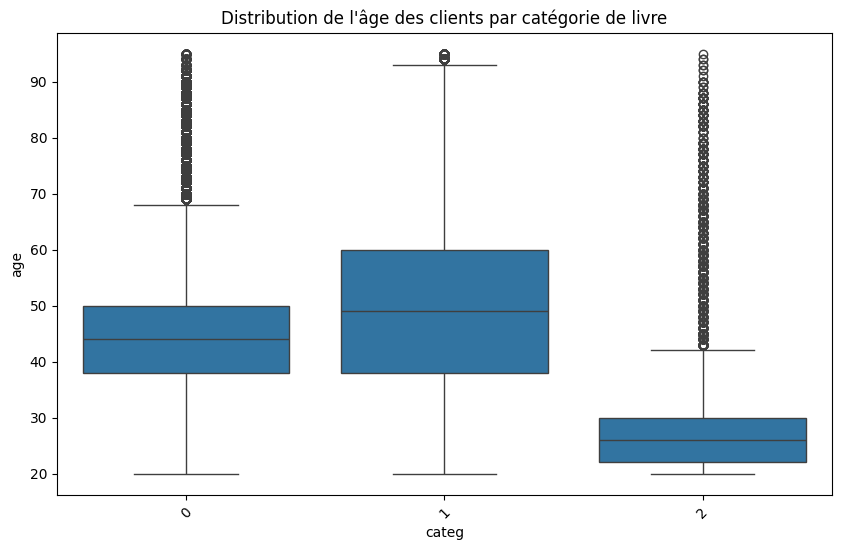

In [73]:
##Distribution de l'âge des clients par catégorie de livre
plt.figure(figsize=(10,6))
sns.boxplot(x='categ', y='age', data=df_corr_categorie)
plt.xticks(rotation=45)
plt.title("Distribution de l'âge des clients par catégorie de livre")
plt.show()

On observe une distribution inégale de l'âge des clients par catégorie de livre acheté.'
La catégorie 2 s'addresse aux clients plus jeunes, tandis que les catégories 0 et 1 s'addresse aux personnes de + de 40ans et semblent avoir une distribution plus homogène

# Analyse sans les clients BtoB

C:\Users\Pimi\AppData\Local\Temp\ipykernel_49244\367105403.py:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  ca_categ_0_monthly = ca_categ_0.resample('M').sum()
C:\Users\Pimi\AppData\Local\Temp\ipykernel_49244\367105403.py:8: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  ca_categ_1_monthly = ca_categ_1.resample('M').sum()
C:\Users\Pimi\AppData\Local\Temp\ipykernel_49244\367105403.py:9: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  ca_categ_2_monthly = ca_categ_2.resample('M').sum()


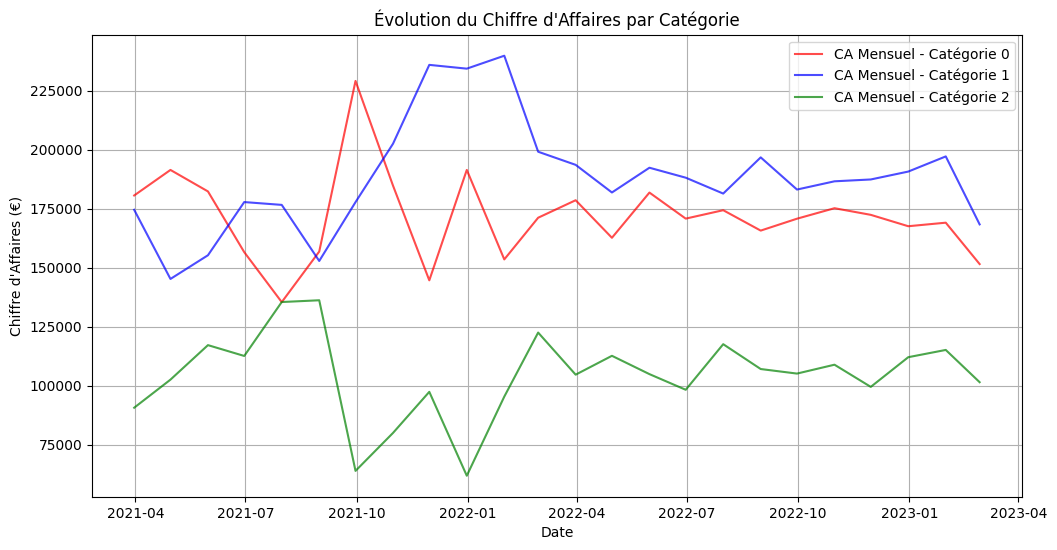

In [74]:
# Filtre les données pour chaque catégorie :
ca_categ_0 = df_merge_filtered[df_merge_filtered['categ'] == 0].set_index('date')['price']
ca_categ_1 = df_merge_filtered[df_merge_filtered['categ'] == 1].set_index('date')['price']
ca_categ_2 = df_merge_filtered[df_merge_filtered['categ'] == 2].set_index('date')['price']

# Rééchantillonne les données par mois et calcul du CA mensuel
ca_categ_0_monthly = ca_categ_0.resample('M').sum()
ca_categ_1_monthly = ca_categ_1.resample('M').sum()
ca_categ_2_monthly = ca_categ_2.resample('M').sum()

# Graphique
plt.figure(figsize=(12, 6))
plt.plot(ca_categ_0_monthly.index, ca_categ_0_monthly, label='CA Mensuel - Catégorie 0', color='red', alpha=0.7)
plt.plot(ca_categ_1_monthly.index, ca_categ_1_monthly, label='CA Mensuel - Catégorie 1', color='blue', alpha=0.7)
plt.plot(ca_categ_2_monthly.index, ca_categ_2_monthly, label='CA Mensuel - Catégorie 2', color='green', alpha=0.7)

plt.xlabel("Date")
plt.ylabel("Chiffre d'Affaires (€)")
plt.title("Évolution du Chiffre d'Affaires par Catégorie")
plt.legend()
plt.grid()
plt.show()

In [75]:
nb_transactions_par_mois = df_merge_filtered.resample('ME', on='date')['session_id'].nunique()
print(nb_transactions_par_mois)

date
2021-03-31    13285
2021-04-30    13014
2021-05-31    13165
2021-06-30    12929
2021-07-31    12685
2021-08-31    12696
2021-09-30    13848
2021-10-31    13995
2021-11-30    13612
2021-12-31    14478
2022-01-31    13999
2022-02-28    13357
2022-03-31    13845
2022-04-30    13129
2022-05-31    13950
2022-06-30    13385
2022-07-31    13696
2022-08-31    13580
2022-09-30    13332
2022-10-31    13678
2022-11-30    13289
2022-12-31    13594
2023-01-31    13793
2023-02-28    12177
Freq: ME, Name: session_id, dtype: int64


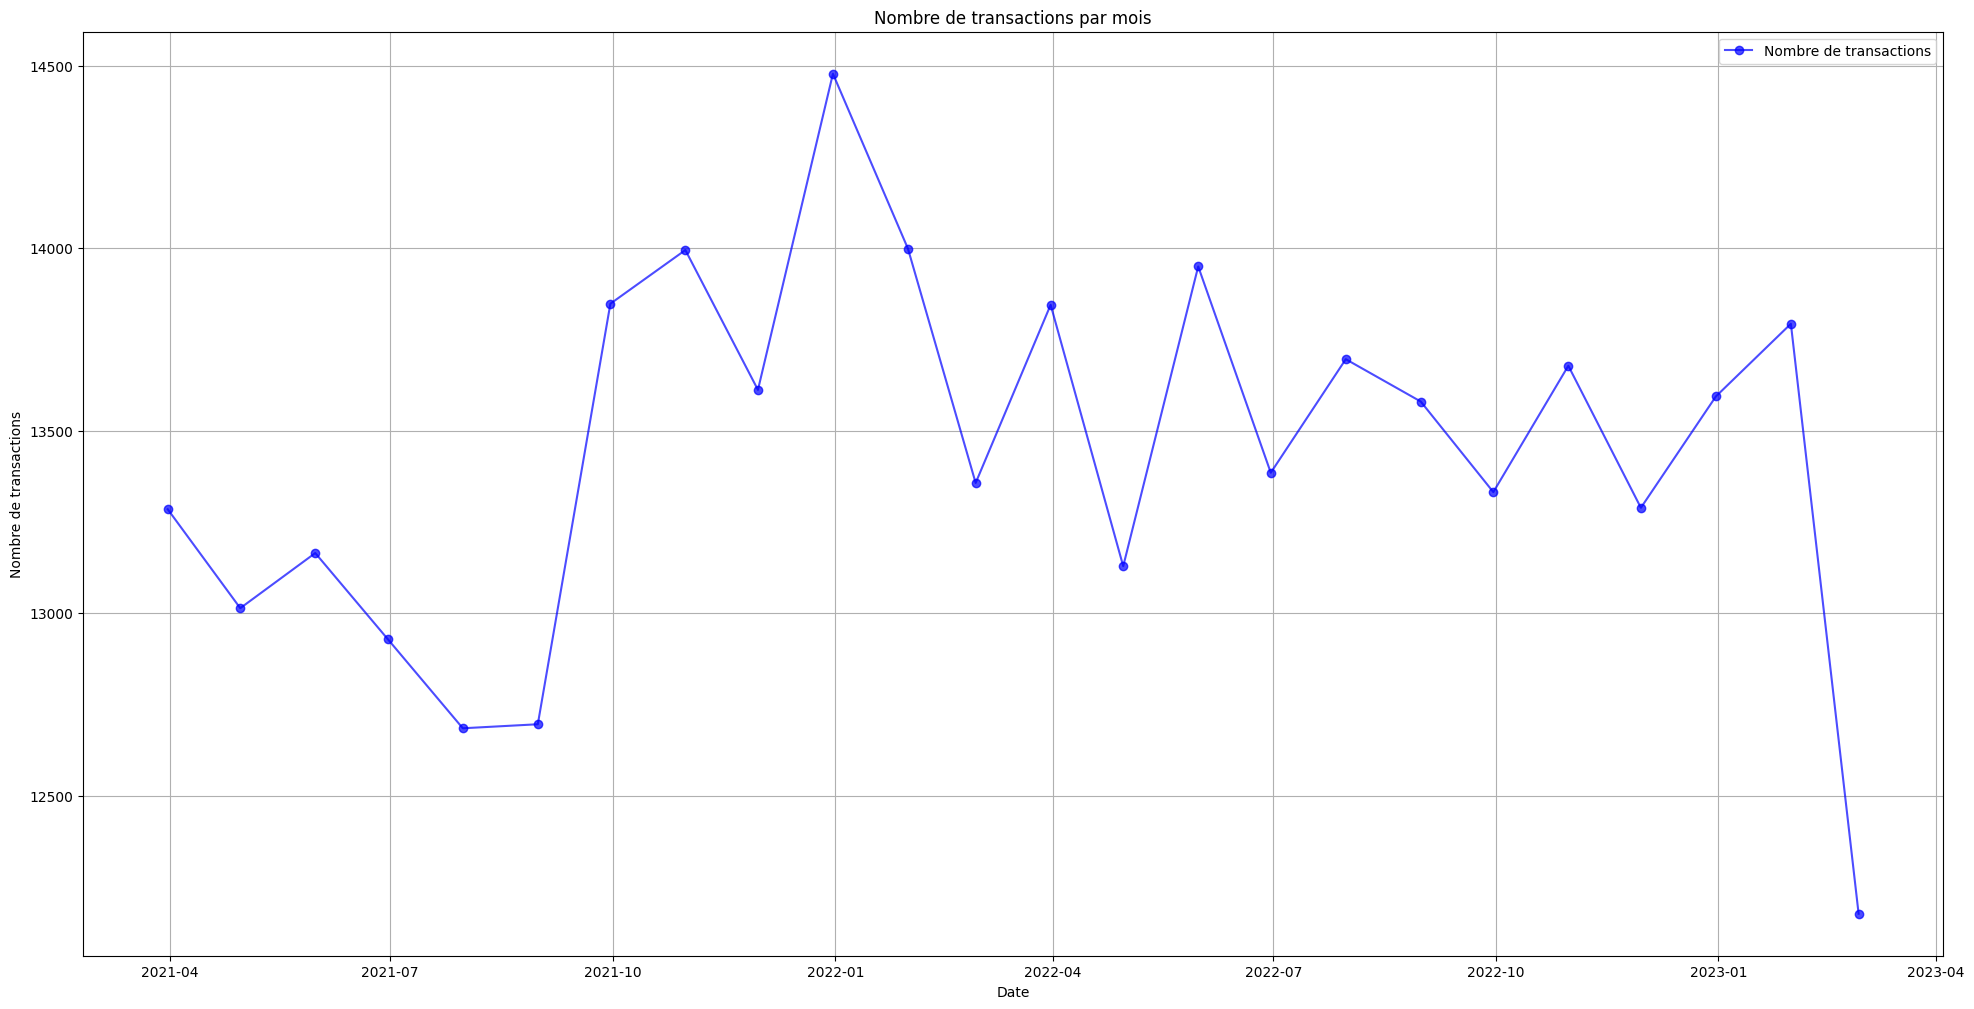

In [76]:
plt.figure(figsize=(24, 12))
plt.plot(nb_transactions_par_mois.index, nb_transactions_par_mois, label='Nombre de transactions', color='blue', alpha=0.7, marker='o')
plt.xlabel("Date")
plt.ylabel("Nombre de transactions")
plt.title("Nombre de transactions par mois")
plt.legend()
plt.grid()
plt.show()

C:\Users\Pimi\AppData\Local\Temp\ipykernel_49244\3355126845.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  ca_par_age = df_merge_filtered.groupby(df_merge_filtered['tranche_age'])['price'].sum().round(2)


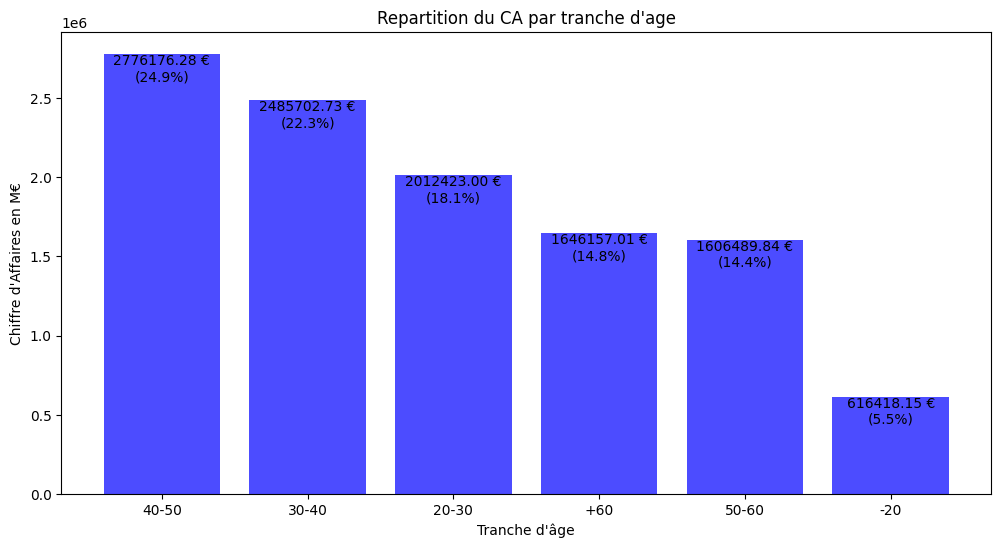

In [77]:
## Chiffre d'affaires par tranche d'âge
ca_par_age = df_merge_filtered.groupby(df_merge_filtered['tranche_age'])['price'].sum().round(2)

total_ca = ca_par_age.sum()
pourcentage_ca = (ca_par_age / total_ca)*100
pourcentage_sorted = pourcentage_ca.sort_values(ascending=False)
ca_par_age_sorted = ca_par_age.sort_values(ascending=False)

plt.figure(figsize=(12, 6)) ## crée une nouvelle figure pour le graphique figsize définit la taille de la figure en pouces : 12 pouces de large et 6 pouces de haut.
bars = plt.bar(pourcentage_sorted.index, ca_par_age_sorted, color='blue', alpha=0.7) 
for bar, pct in zip(bars, pourcentage_sorted): ##On boucle à la fois sur les barres et les pourcentages et zip(bars, pourcentage_sorted) permet d'associer chaque barre à son pourcentage.
    height = bar.get_height()  # Récupère la hauteur de la barre
    plt.text(bar.get_x() + bar.get_width() / 2, height, 
             f'{height:.2f} €\n({pct:.1f}%)',  # Affiche la valeur + pourcentage
             ha='center', va='top', fontsize=10, color='black')
plt.xlabel("Tranche d'âge")
plt.ylabel("Chiffre d'Affaires en M€")
plt.title("Repartition du CA par tranche d'age")

plt.show()

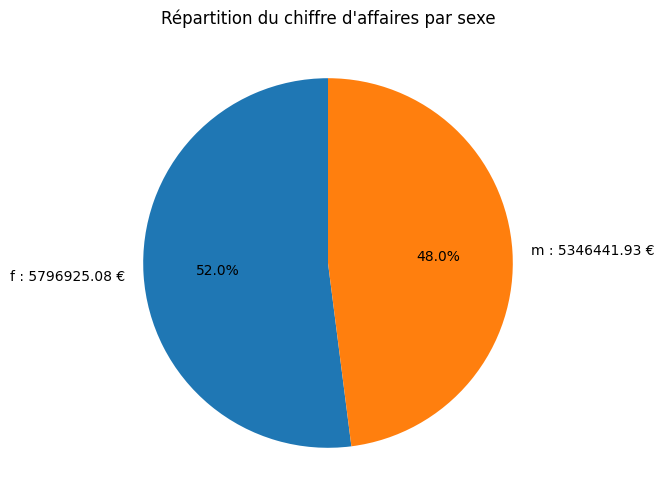

In [78]:
ca_par_sexe = df_merge_filtered.groupby(df_merge_filtered['sex'])['price'].sum().round(2)

labels = [f'{sexe} : {ca} €' for sexe, ca in zip(ca_par_sexe.index, ca_par_sexe)]
plt.figure(figsize=(12, 6))
plt.pie(ca_par_sexe, labels=labels, autopct='%1.1f%%', startangle=90)
plt.title("Répartition du chiffre d'affaires par sexe")
plt.show()